In [5]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from scipy import signal
from scipy.stats import kurtosis, skew
from dask.distributed import Client
from os import listdir
from os.path import isfile, join

In [6]:
client = Client(n_workers=24, threads_per_worker=2, memory_limit=12e9)
client

/Users/pvb/miniconda3/envs/DataAnalisis/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50230 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:50230/status,
Dashboard: http://127.0.0.1:50230/status,Workers: 24
Total threads: 48,Total memory: 268.22 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50231,Workers: 24
Dashboard: http://127.0.0.1:50230/status,Total threads: 48
Started: Just now,Total memory: 268.22 GiB
Comm: tcp://127.0.0.1:50282,Total threads: 2
Dashboard: http://127.0.0.1:50289/status,Memory: 11.18 GiB
Nanny: tcp://127.0.0.1:50234,


In [7]:
ds = xr.open_dataset('./Data/sla_NorthPacific7D_corrected.nc')
sla_anom=ds.sla_anom

## Statistics

### Standart deviation

In [8]:
sla_anom_std=np.std(sla_anom, axis=0)

/Users/pvb/miniconda3/envs/DataAnalisis/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


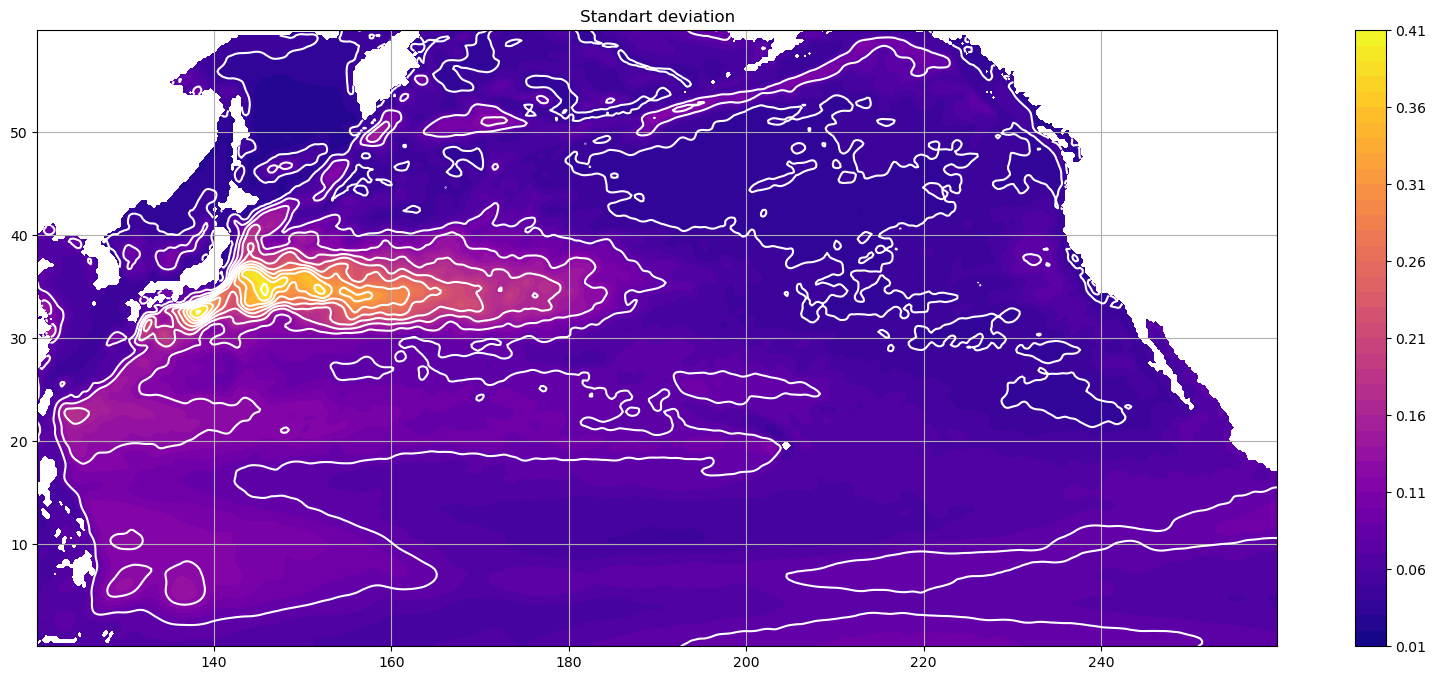

In [9]:
fig, ax = plt.subplots(figsize=(20,8))
CS=ax.contourf(sla_anom_std.longitude,sla_anom_std.latitude,sla_anom_std,40,cmap='plasma')
ax.contour(sla_anom_std.longitude,sla_anom_std.latitude,sla_anom_std,10,colors='w')
ax.set_title('Standart deviation')
ax.grid()
fig.colorbar(CS);

In [10]:
sla_anom_skew=skew(sla_anom, axis=0)

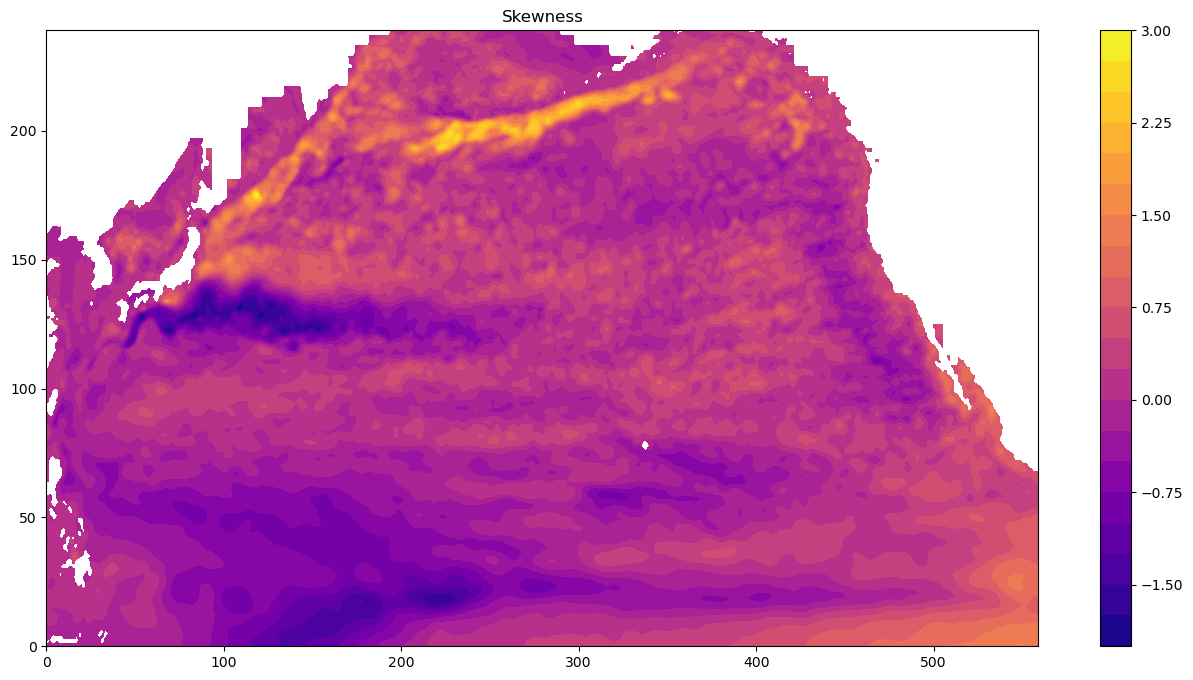

In [11]:
fig, ax = plt.subplots(figsize=(16,8))
CS=ax.contourf(sla_anom_skew,20,cmap='plasma')
ax.set_title('Skewness')
fig.colorbar(CS);

In [12]:
sla_anom_kurtosis=kurtosis(sla_anom, axis=0)

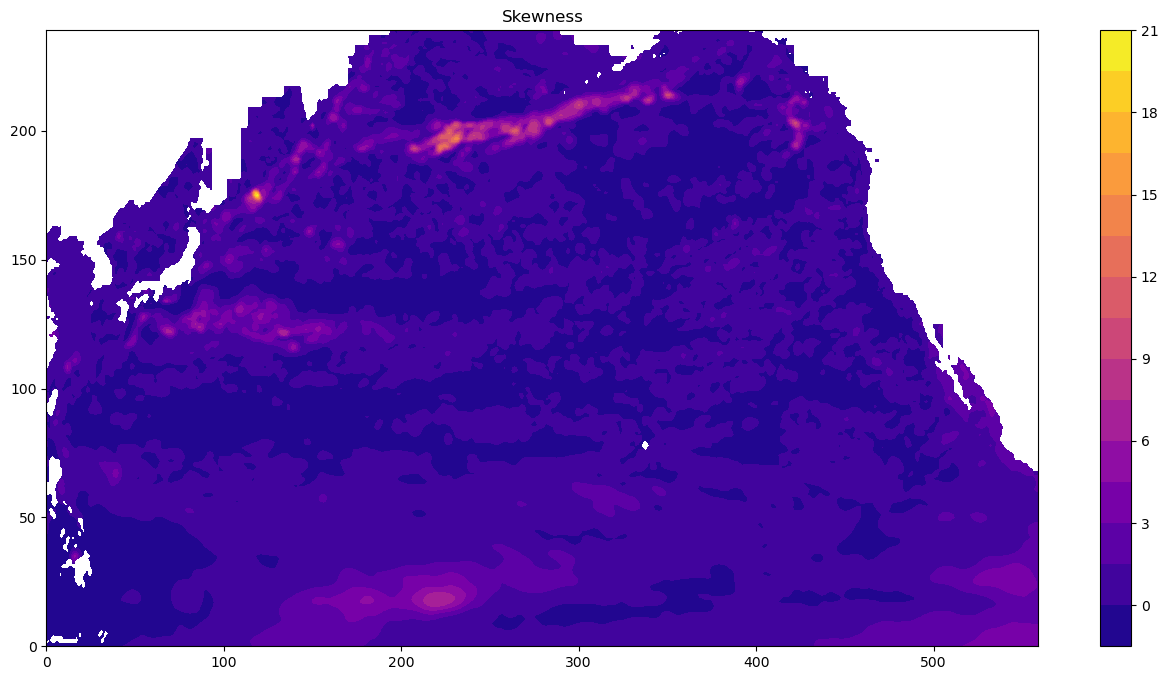

In [13]:
fig, ax = plt.subplots(figsize=(16,8))
CS=ax.contourf(sla_anom_kurtosis,20,cmap='plasma')
ax.set_title('Skewness')
fig.colorbar(CS);

### Spectral analysis

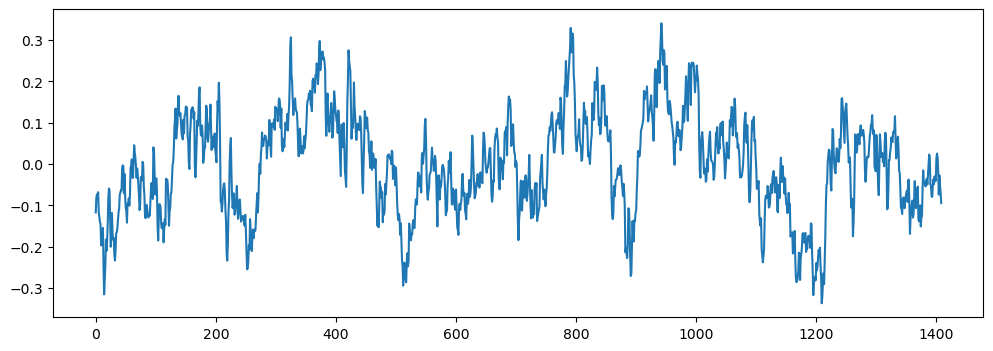

In [14]:
i1=20
j1=40

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(sla_anom[:,i1,j1])

In [15]:
freqsA, timesA, spectrogram = signal.spectrogram(sla_anom[:,i1,j1])
freqsA, psdA = signal.welch(sla_anom[:,i1,j1])

Text(0, 0.5, 'Power')

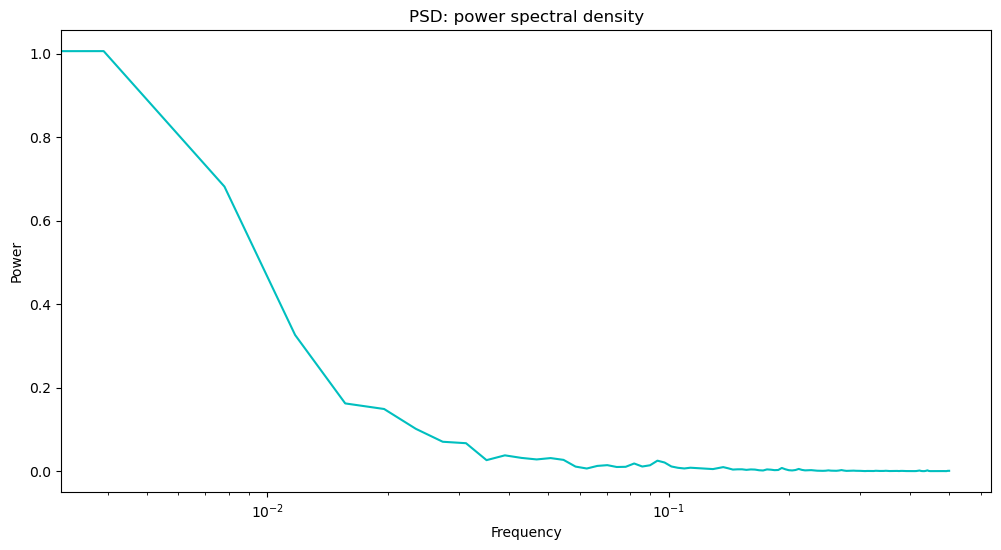

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.semilogx(freqsA,psdA,'c')
ax.set_title('PSD: power spectral density')
ax.set_xlabel('Frequency')
ax.set_ylabel('Power')

In [17]:
def spectrum1(h, dt=1):
    """
    First cut at spectral estimation: very crude.
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

Text(0.5, 1.0, 'Power Spectrum')

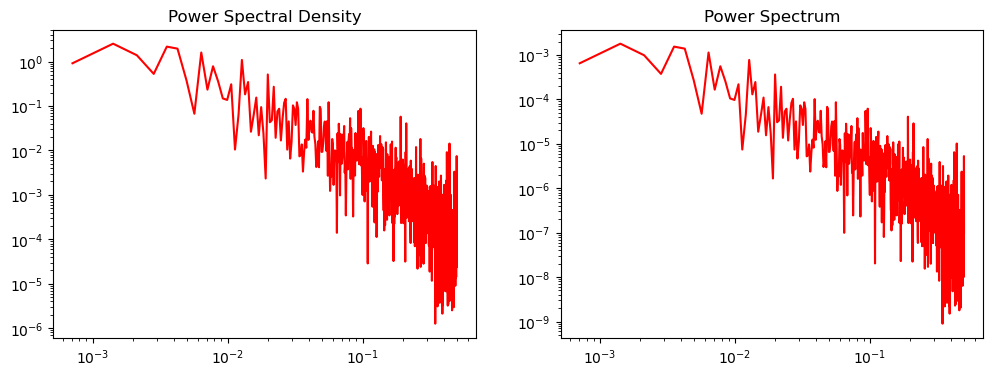

In [18]:
freqs1, ps1, psd1 = spectrum1(sla_anom[:,i1,j1], dt=1)

fig, axs = plt.subplots(ncols=2, sharex=True, figsize=(12,4))
axs[0].loglog(freqs1, psd1, 'r')
axs[1].loglog(freqs1, ps1, 'r')
axs[0].set_title('Power Spectral Density')
axs[1].set_title('Power Spectrum')

In [19]:
def spectrum2(h, dt=1, nsmooth=5):
    """
    Add simple boxcar smoothing to the raw periodogram.
    
    Chop off the ends to avoid end effects.
    """
    freqs, ps, psd = spectrum1(h, dt=dt)
    weights = np.ones(nsmooth, dtype=float) / nsmooth
    ps_s = np.convolve(ps, weights, mode='valid')
    psd_s = np.convolve(psd, weights, mode='valid')
    freqs_s = np.convolve(freqs, weights, mode='valid')
    return freqs_s, ps_s, psd_s
def spectrum3(h, dt=1, nsmooth=5):
    """
    Detrend first.
    """
    t = np.arange(len(h))
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return spectrum2(h_detrended, dt=dt, nsmooth=nsmooth)

Text(0.5, 1.0, 'Power Spectrum')

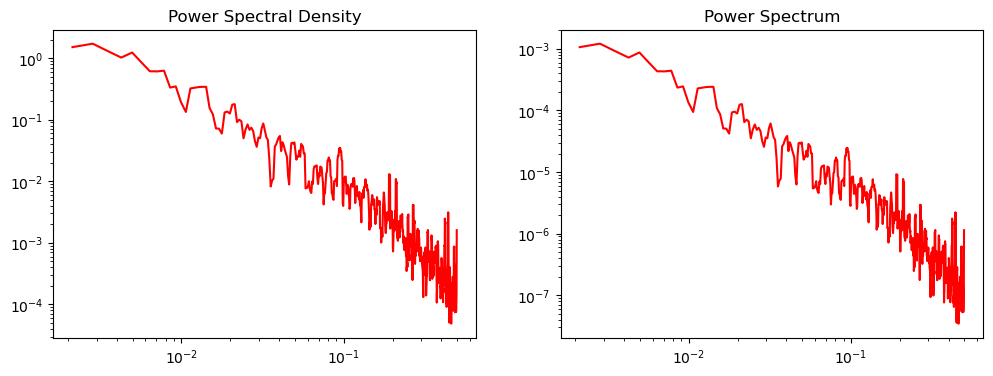

In [20]:
freqs1, ps1, psd1 = spectrum2(sla_anom[:,i1,j1], dt=1)

fig, axs = plt.subplots(ncols=2, sharex=True, figsize=(12,4))
axs[0].loglog(freqs1, psd1, 'r')
axs[1].loglog(freqs1, ps1, 'r')
axs[0].set_title('Power Spectral Density')
axs[1].set_title('Power Spectrum')

In [21]:
def detrend(h):
    n = len(h)
    t = np.arange(n)
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return h_detrended
    
def quadwin(n):
    """
    Quadratic (or "Welch") window
    """
    t = np.arange(n)
    win = 1 - ((t - 0.5 * n) / (0.5 * n)) ** 2
    return win

def spectrum4(h, dt=1, nsmooth=5):
    """
    Detrend and apply a quadratic window.
    """
    n = len(h)

    h_detrended = detrend(h)
    
    winweights = quadwin(n)
    h_win = h_detrended * winweights
    
    freqs, ps, psd = spectrum2(h_win, dt=dt, nsmooth=nsmooth)
    
    # Compensate for the energy suppressed by the window.
    psd *= n / (winweights**2).sum()
    ps *= n**2 / winweights.sum()**2
    
    return freqs, ps, psd

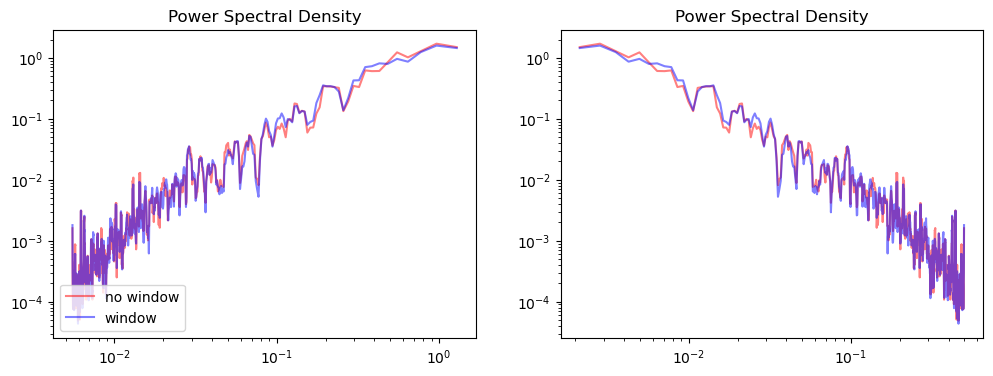

In [22]:
freqs1, ps1, psd1 = spectrum4(sla_anom[:,i1,j1], dt=1)
freqs1a, ps1a, psd1a = spectrum3(sla_anom[:,i1,j1], dt=1)

fig, axs = plt.subplots(ncols=2,figsize=(12,4))
axs[0].loglog((1/freqs1)/365, psd1a, 'r', alpha=0.5, label='no window')
axs[0].loglog((1/freqs1)/365, psd1, 'b', alpha=0.5, label='window')

axs[0].legend(loc='lower left')

axs[1].loglog(freqs1, psd1a, 'r', 
              freqs1, psd1, 'b', alpha=0.5)
axs[0].set_title('Power Spectral Density')
axs[1].set_title('Power Spectral Density');

In [23]:
1/freqs1

array([469.66666667, 352.25      , 281.8       , 234.83333333,
       201.28571429, 176.125     , 156.55555556, 140.9       ,
       128.09090909, 117.41666667, 108.38461538, 100.64285714,
        93.93333333,  88.0625    ,  82.88235294,  78.27777778,
        74.15789474,  70.45      ,  67.0952381 ,  64.04545455,
        61.26086957,  58.70833333,  56.36      ,  54.19230769,
        52.18518519,  50.32142857,  48.5862069 ,  46.96666667,
        45.4516129 ,  44.03125   ,  42.6969697 ,  41.44117647,
        40.25714286,  39.13888889,  38.08108108,  37.07894737,
        36.12820513,  35.225     ,  34.36585366,  33.54761905,
        32.76744186,  32.02272727,  31.31111111,  30.63043478,
        29.9787234 ,  29.35416667,  28.75510204,  28.18      ,
        27.62745098,  27.09615385,  26.58490566,  26.09259259,
        25.61818182,  25.16071429,  24.71929825,  24.29310345,
        23.88135593,  23.48333333,  23.09836066,  22.72580645,
        22.36507937,  22.015625  ,  21.67692308,  21.34

## Serie en SAGA

In [24]:
serie_zona=sla_anom.sel(longitude=slice(10,20),latitude=slice(-45,-35)).mean(dim='longitude').mean(dim='latitude')

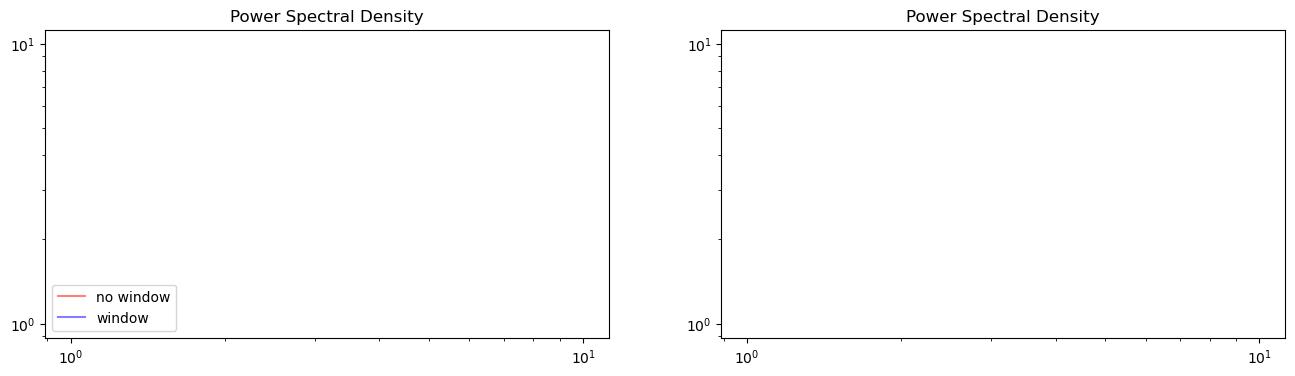

In [25]:
freqs1, ps1, psd1 = spectrum4(serie_zona, dt=1)
freqs1a, ps1a, psd1a = spectrum3(serie_zona, dt=1)

fig, axs = plt.subplots(ncols=2,figsize=(16,4))
axs[0].loglog((1/freqs1)/365, psd1a, 'r', alpha=0.5, label='no window')
axs[0].loglog((1/freqs1)/365, psd1, 'b', alpha=0.5, label='window')

axs[0].legend(loc='lower left')

axs[1].loglog(freqs1, psd1a, 'r', 
              freqs1, psd1, 'b', alpha=0.5)
axs[0].set_title('Power Spectral Density')
axs[1].set_title('Power Spectral Density');